<a href="https://colab.research.google.com/github/NekoMonci12/Machine-Learning-Brazilian-E-Commerce/blob/main/ML_Muhammad_Tamir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Data: Brazilian E-Commerce Public
- **Nama:** Muhammad Tamir

## Menentukan Pertanyaan Bisnis

- Negara bagian (State) mana di Brazil yang memiliki konsentrasi pelanggan tertinggi, dan bagaimana distribusi total pendapatan (revenue) di antara negara bagian tersebut?
- Apakah terdapat korelasi antara lama waktu pengiriman (delivery time) dengan skor ulasan (review score) yang diberikan oleh pelanggan?

## Import Semua Packages/Library yang Digunakan

In [184]:
import os
import re
import unicodedata
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

### Gathering Data

#### Setup Kaggle

In [185]:
dataset_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

files = [
    f for f in os.listdir(dataset_path)
    if f.endswith(".csv")
]

data = {}

for file_path in files:
    key = file_path.removesuffix(".csv")

    df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "olistbr/brazilian-ecommerce",
        file_path,
    )

    data[key] = df

print("\n" + "="*56)
print(f"TOTAL DATASET DIMUAT: {len(data)}")
print("="*56)

for i, name in enumerate(sorted(data.keys()), 1):
    row_count = len(data[name])
    print(f"{i}. {name:<35} | {row_count:>9,} baris")

print("="*56)

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.

TOTAL DATASET DIMUAT: 9
1. olist_customers_dataset             |    99,441 baris
2. olist_geolocation_dataset           | 1,000,163 baris
3. olist_order_items_dataset           |   112,650 baris
4. olist_order_payments_dataset        |   103,886 baris
5. olis

**Insight:**
- xxx
- xxx

#### Setup City & State Mapping

In [186]:
state_mapping = {
    "acre": "AC",
    "alagoas": "AL",
    "amapa": "AP",
    "amazonas": "AM",
    "bahia": "BA",
    "ceara": "CE",
    "distrito federal":"DF",
    "espirito santo": "ES",
    "goias": "GO",
    "maranhao": "MA",
    "mato grosso": "MT",
    "mato grosso do sul": "MS",
    "minas gerais": "MG",
    "para": "PA",
    "paraiba": "PB",
    "parana": "PR",
    "pernambuco": "PE",
    "piaui": "PI",
    "rio de janeiro": "RJ",
    "rio grande do norte": "RN",
    "rio grande do sul": "RS",
    "rondonia": "RO",
    "roraima": "RR",
    "santa catarina": "SC",
    "sao paulo": "SP",
    "sergipe": "SE",
    "tocantins": "TO"
}

### Assessing Data

#### Dataset Declaration

In [187]:
customers = data["olist_customers_dataset"]
geolocation = data["olist_geolocation_dataset"]
order_item = data["olist_order_items_dataset"]
order_payment = data["olist_order_payments_dataset"]
order_review = data["olist_order_reviews_dataset"]
orders = data["olist_orders_dataset"]
products = data["olist_products_dataset"]
sellers = data["olist_sellers_dataset"]
product_category = data["product_category_name_translation"]

#### Dataset Function

##### Product Function

In [188]:
def get_product_category(product_id, translate=False):
    category_series = products[products['product_id'] == product_id]['product_category_name']
    if not category_series.empty:
        category = category_series.values[0]
        if translate and 'product_category_name_translation' in data:
            translation = product_category[product_category['product_category_name'] == category]['product_category_name_english']
            if not translation.empty:
                return translation.values[0]

        return category
    else:
        return "Product ID tidak ditemukan"

#### Assessing Data Result

**Insight:**
- xxx
- xxx

### Cleaning Data

#### Functions

##### Cleaning Utils

In [189]:
def normalize_unicode(text):
    if isinstance(text, str):
        return unicodedata.normalize("NFD", text)
    return text

def clean_brazilian_cities(text):
    if isinstance(text, str):
        text = text.replace('£', 'a')
        text = normalize_unicode(text)
        text = text.encode('ascii', 'ignore').decode("utf-8")
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        return text.lower().strip()
    return text

def remove_duplicates_data(df, subset_columns):
    duplicate_count = df.duplicated(subset=subset_columns).sum()
    df_cleaned = df.drop_duplicates(subset=subset_columns, keep='first').copy()

    print(f"--- Laporan Pembersihan Duplikasi ---")
    print(f"Total baris awal      : {len(df)}")
    print(f"Jumlah duplikat literal: {duplicate_count}")
    print(f"Total baris sekarang  : {len(df_cleaned)}")
    print(f"-------------------------------------")

    return df_cleaned

def remove_mismatched_data(df_target, col_target, df_ref, col_ref):
    valid_values = df_ref[col_ref].unique()
    initial_count = len(df_target)
    df_cleaned = df_target[df_target[col_target].isin(valid_values)].copy()
    removed_count = initial_count - len(df_cleaned)

    print(f"--- Laporan Pembersihan Integritas ---")
    print(f"Dataset Target       : {initial_count} baris")
    print(f"Data tidak ditemukan : {removed_count} baris dihapus")
    print(f"Dataset Akhir        : {len(df_cleaned)} baris")
    print(f"---------------------------------------")

    return df_cleaned

def remove_null_rows(df, subset_columns):
    initial_count = len(df)
    df_cleaned = df.dropna(subset=subset_columns, how='any').copy()
    removed_count = initial_count - len(df_cleaned)

    print(f"--- Laporan Penanganan Missing Value ---")
    print(f"Dataset             : {initial_count} baris")
    print(f"Baris dengan null    : {removed_count} baris dihapus")
    print(f"Dataset Bersih      : {len(df_cleaned)} baris")
    print(f"----------------------------------------")

    return df_cleaned

##### City & State Validation

In [190]:
geo_reference = customers[['customer_city', 'customer_state']].drop_duplicates()
def check_location(city=None, state=None):
    if city: city = clean_brazilian_cities(city)
    if state: state = state.upper()

    if city and state:
        exists = not geo_reference[(geo_reference['customer_city'] == city) &
                                   (geo_reference['customer_state'] == state)].empty
        return exists

    elif city:
        states = geo_reference[geo_reference['customer_city'] == city]['customer_state'].unique()
        return f"{list(states)}" if len(states) > 0 else "Kota tidak ditemukan."

    elif state:
        cities = geo_reference[geo_reference['customer_state'] == state]['customer_city'].unique()
        return f"{list(cities[:5])}" if len(cities) > 0 else "State tidak ditemukan."

##### Date & Time Utils

In [191]:
def convert_to_datetime(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')

    return df

#### Alter Format

##### Date & Time String To Datetime

In [192]:
orders = convert_to_datetime(orders, 'order_purchase_timestamp')
orders = convert_to_datetime(orders, 'order_approved_at')
orders = convert_to_datetime(orders, 'order_delivered_carrier_date')
orders = convert_to_datetime(orders, 'order_delivered_customer_date')
orders = convert_to_datetime(orders, 'order_estimated_delivery_date')

#### Cleaning Process

##### Customers Dataset

In [193]:
remove_duplicates_data(customers, ['customer_unique_id'])

--- Laporan Pembersihan Duplikasi ---
Total baris awal      : 99441
Jumlah duplikat literal: 3345
Total baris sekarang  : 96096
-------------------------------------


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


##### Product Dataset

In [194]:
remove_null_rows(products, ["product_category_name"])

--- Laporan Penanganan Missing Value ---
Dataset             : 32951 baris
Baris dengan null    : 610 baris dihapus
Dataset Bersih      : 32341 baris
----------------------------------------


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


##### Order Dataset

In [195]:
remove_mismatched_data(order_item, 'order_id', orders, 'order_id')

--- Laporan Pembersihan Integritas ---
Dataset Target       : 112650 baris
Data tidak ditemukan : 0 baris dihapus
Dataset Akhir        : 112650 baris
---------------------------------------


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [196]:
remove_mismatched_data(order_payment, 'order_id', orders, 'order_id')

--- Laporan Pembersihan Integritas ---
Dataset Target       : 103886 baris
Data tidak ditemukan : 0 baris dihapus
Dataset Akhir        : 103886 baris
---------------------------------------


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [197]:
remove_mismatched_data(order_review, 'order_id', orders, 'order_id')

--- Laporan Pembersihan Integritas ---
Dataset Target       : 99224 baris
Data tidak ditemukan : 0 baris dihapus
Dataset Akhir        : 99224 baris
---------------------------------------


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [198]:
remove_mismatched_data(order_item, 'product_id', products, 'product_id')

--- Laporan Pembersihan Integritas ---
Dataset Target       : 112650 baris
Data tidak ditemukan : 0 baris dihapus
Dataset Akhir        : 112650 baris
---------------------------------------


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


##### Cleaning Results


**Insight:**
- xxx
- xxx

## Exploratory Data Analysis (EDA)

### Functions

In [199]:
def top_data(df, n=5):
    return df.head(n)

### Statistik Deskriptif

#### Functions

In [200]:
def dataset_summary(dataframes: dict):
    summary = []
    for name, df in dataframes.items():
        if df is None:
            summary.append({
                "dataset": name,
                "rows": 0,
                "columns": 0,
                "status": "NOT LOADED"
            })
        else:
            summary.append({
                "dataset": name,
                "rows": df.shape[0],
                "columns": df.shape[1],
                "status": "OK"
            })

    return pd.DataFrame(summary)

def orders_datetime_ranges(orders_df):
    datetime_cols = [
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ]

    summary = []

    for col in datetime_cols:
        temp = pd.to_datetime(orders_df[col], errors='coerce')

        summary.append({
            "column": col,
            "start_date": temp.min(),
            "end_date": temp.max(),
            "missing_pct": round(temp.isna().mean() * 100, 2)
        })

    return pd.DataFrame(summary)

def order_delivery_summary(orders_df):
    data = {
        "stage": [
            "Approved",
            "Delivered to Carrier",
            "Delivered to Customer"
        ],
        "order_count": [
            orders_df['order_approved_at'].notna().sum(),
            orders_df['order_delivered_carrier_date'].notna().sum(),
            orders_df['order_delivered_customer_date'].notna().sum()
        ]
    }
    return pd.DataFrame(data)

def order_status_summary(orders_df):
    return (
        orders_df['order_status']
        .value_counts()
        .reset_index()
        .rename(columns={
            'index': 'order_status',
            'order_status': 'order_count'
        })
    )

def customers_per_state(customers_df):
    return (
        customers_df
        .groupby('customer_state')['customer_id']
        .nunique()
        .reset_index(name='total_customers')
        .sort_values('total_customers', ascending=False)
    )

def customers_state_percentage(cust_state_df):
    total = cust_state_df['total_customers'].sum()
    df = cust_state_df.copy()
    df['percentage'] = (df['total_customers'] / total * 100).round(2)
    return df

def customer_state_statistics(cust_state_df):
    stats = {
        "mean_customers_per_state": cust_state_df['total_customers'].mean(),
        "median_customers_per_state": cust_state_df['total_customers'].median(),
        "skewness": cust_state_df['total_customers'].skew()
    }
    return stats

def revenue_per_state(orders_df, customers_df, payments_df):
    orders_customers = orders_df.merge(
        customers_df[['customer_id', 'customer_state']],
        on='customer_id',
        how='left'
    )

    full_df = orders_customers.merge(
        payments_df[['order_id', 'payment_value']],
        on='order_id',
        how='left'
    )

    revenue_state = (
        full_df
        .groupby('customer_state')['payment_value']
        .sum()
        .reset_index(name='total_revenue')
        .sort_values('total_revenue', ascending=False)
    )

    return revenue_state


#### Dataset Summary

In [201]:
datasets = {
    "customers": customers,
    "geolocation": geolocation,
    "order_items": order_item,
    "order_payments": order_payment,
    "order_reviews": order_review,
    "orders": orders,
    "products": products,
    "sellers": sellers,
    "product_category_translation": product_category
}

dataset_summary(datasets)


,dataset,rows,columns,status
0,customers,99441,5,OK
1,geolocation,1000163,5,OK
2,order_items,112650,7,OK
3,order_payments,103886,5,OK
4,order_reviews,99224,7,OK
5,orders,99441,8,OK
6,products,32951,9,OK
7,sellers,3095,4,OK
8,product_category_translation,71,2,OK


#### Orders Summary

In [202]:
orders_datetime_ranges(orders)


,column,start_date,end_date,missing_pct
0,order_purchase_timestamp,2016-09-04 21:15:19,2018-10-17 17:30:18,0.00
1,order_approved_at,2016-09-15 12:16:38,2018-09-03 17:40:06,0.16
2,order_delivered_carrier_date,2016-10-08 10:34:01,2018-09-11 19:48:28,1.79
3,order_delivered_customer_date,2016-10-11 13:46:32,2018-10-17 13:22:46,2.98
4,order_estimated_delivery_date,2016-09-30 00:00:00,2018-11-12 00:00:00,0.00


In [203]:
order_status_summary(orders)

,order_count,count
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [204]:
order_delivery_summary(orders)

,stage,order_count
0,Approved,99281
1,Delivered to Carrier,97658
2,Delivered to Customer,96476


#### Customers Summary

In [205]:
cust_state = customers_per_state(customers)
cust_state_pct = customers_state_percentage(cust_state)

top_data(cust_state_pct, n=10)

,customer_state,total_customers,percentage
25,SP,41746,41.98
18,RJ,12852,12.92
10,MG,11635,11.70
22,RS,5466,5.50
17,PR,5045,5.07
23,SC,3637,3.66
4,BA,3380,3.40
6,DF,2140,2.15
7,ES,2033,2.04
8,GO,2020,2.03


#### Revenue Summary

In [206]:
revenue_state = revenue_per_state(orders, customers, order_payment)

top_data(revenue_state, n=10)

,customer_state,total_revenue
25,SP,5998226.96
18,RJ,2144379.69
10,MG,1872257.26
22,RS,890898.54
17,PR,811156.38
23,SC,623086.43
4,BA,616645.82
6,DF,355141.08
8,GO,350092.31
7,ES,325967.55


### Explore

#### Functions

In [207]:
def customers_vs_revenue_per_state(customers_df, orders_df, payments_df):
    customers_state = (
        customers_df
        .groupby('customer_state')['customer_id']
        .nunique()
        .reset_index(name='total_customers')
    )

    orders_customers = orders_df.merge(
        customers_df[['customer_id', 'customer_state']],
        on='customer_id',
        how='left'
    )

    orders_payments = orders_customers.merge(
        payments_df[['order_id', 'payment_value']],
        on='order_id',
        how='left'
    )

    revenue_state = (
        orders_payments
        .groupby('customer_state')['payment_value']
        .sum()
        .reset_index(name='total_revenue')
    )

    result = customers_state.merge(
        revenue_state,
        on='customer_state',
        how='inner'
    )

    return result.sort_values('total_customers', ascending=False)

def avg_revenue_per_customer_state(customers_df, orders_df, payments_df):
    orders_customers = orders_df.merge(
        customers_df[['customer_id', 'customer_state']],
        on='customer_id',
        how='left'
    )

    full_df = orders_customers.merge(
        payments_df[['order_id', 'payment_value']],
        on='order_id',
        how='left'
    )

    agg = (
        full_df
        .groupby('customer_state')
        .agg(
            total_revenue=('payment_value', 'sum'),
            total_customers=('customer_id', 'nunique')
        )
        .reset_index()
    )

    agg['avg_revenue_per_customer'] = (
        agg['total_revenue'] / agg['total_customers']
    )

    return agg.sort_values('avg_revenue_per_customer', ascending=False)

def avg_revenue_per_order_state(customers_df, orders_df, payments_df):
    orders_customers = orders_df.merge(
        customers_df[['customer_id', 'customer_state']],
        on='customer_id',
        how='left'
    )

    full_df = orders_customers.merge(
        payments_df[['order_id', 'payment_value']],
        on='order_id',
        how='left'
    )

    agg = (
        full_df
        .groupby('customer_state')
        .agg(
            total_revenue=('payment_value', 'sum'),
            total_orders=('order_id', 'nunique')
        )
        .reset_index()
    )

    agg['avg_revenue_per_order'] = (
        agg['total_revenue'] / agg['total_orders']
    )

    return agg.sort_values('avg_revenue_per_order', ascending=False)

def prepare_delivery_review_df(orders, order_reviews):
    df = (
        orders[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date']]
        .merge(order_reviews[['order_id', 'review_score']], on='order_id', how='inner')
    )

    df = df.dropna(subset=['order_delivered_customer_date'])

    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

    df['delivery_time_days'] = (
        df['order_delivered_customer_date'] - df['order_purchase_timestamp']
    ).dt.days

    return df[df['delivery_time_days'] >= 0]


#### Customer VS Revenue (States)

In [208]:
state_summary = customers_vs_revenue_per_state(customers, orders, order_payment)

top_data(state_summary, n=10)

,customer_state,total_customers,total_revenue
25,SP,41746,5998226.96
18,RJ,12852,2144379.69
10,MG,11635,1872257.26
22,RS,5466,890898.54
17,PR,5045,811156.38
23,SC,3637,623086.43
4,BA,3380,616645.82
6,DF,2140,355141.08
7,ES,2033,325967.55
8,GO,2020,350092.31


#### Average Revenue Per Order (States)

In [209]:
avg_revenue_per_order_state = avg_revenue_per_order_state(customers, orders, order_payment)

top_data(avg_revenue_per_order_state, n=10)

,customer_state,total_revenue,total_orders,avg_revenue_per_order
14,PB,141545.72,536,264.077836
0,AC,19680.62,81,242.970617
20,RO,60866.20,253,240.577866
3,AP,16262.80,68,239.158824
1,AL,96962.06,413,234.774964
13,PA,218295.85,975,223.893179
26,TO,61485.33,280,219.590464
16,PI,108523.97,495,219.240343
21,RR,10064.62,46,218.796087
24,SE,75246.25,350,214.989286


#### Average Revenue Per Customer (States)

In [210]:
avg_rev_customer = avg_revenue_per_customer_state(customers, orders, order_payment)

top_data(avg_rev_customer, n=10)

,customer_state,total_revenue,total_customers,avg_revenue_per_customer
14,PB,141545.72,536,264.077836
0,AC,19680.62,81,242.970617
20,RO,60866.20,253,240.577866
3,AP,16262.80,68,239.158824
1,AL,96962.06,413,234.774964
13,PA,218295.85,975,223.893179
26,TO,61485.33,280,219.590464
16,PI,108523.97,495,219.240343
21,RR,10064.62,46,218.796087
24,SE,75246.25,350,214.989286


#### Delivery & Review

In [211]:
delivery_review = prepare_delivery_review_df(orders, order_review)

top_data(delivery_review, n=10)


,order_id,order_purchase_timestamp,order_delivered_customer_date,review_score,delivery_time_days
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,4,8
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,4,13
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,5,9
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,5,13
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,5,2
5,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,2017-07-26 10:57:55,4,16
7,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05-26 12:55:51,5,9
8,76c6e866289321a7c93b82b54852dc33,2017-01-23 18:29:09,2017-02-02 14:08:10,1,9
9,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29 11:55:02,2017-08-16 17:14:30,5,18
10,e6ce16cb79ec1d90b1da9085a6118aeb,2017-05-16 19:41:10,2017-05-29 11:18:31,1,12


In [212]:
delivery_review[['delivery_time_days', 'review_score']].describe()

,delivery_time_days,review_score
count,96359.000000,96359.000000
mean,12.058957,4.155554
std,9.463076,1.285108
min,0.000000,1.000000
25%,6.000000,4.000000
50%,10.000000,5.000000
75%,15.000000,5.000000
max,208.000000,5.000000


#### Insight

**Insight:**
- Sao Paulo (SP) mendominasi secara absolut, baik dari sisi jumlah pelanggan maupun total revenue.
- Lima state teratas (SP, RJ, MG, RS, PR) menyumbang mayoritas pelanggan dan revenue, menunjukkan konsentrasi geografis yang tinggi.

## Visualization & Explanatory Analysis

### Pertanyaan 1:

#### Functions

In [213]:
def plot_top_states_by_customers(cust_state_df, top_n=10):
    df = (
        cust_state_df
        .sort_values('total_customers', ascending=False)
        .head(top_n)
    )
    plt.figure(figsize=(10, 6))
    plt.bar(df['customer_state'], df['total_customers'])
    plt.xlabel("State")
    plt.ylabel("Total Customers")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_top_states_by_revenue(revenue_state_df, top_n=10):
    df = (
        revenue_state_df
        .sort_values('total_revenue', ascending=False)
        .head(top_n)
    )
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(df['customer_state'], df['total_revenue'] / 1_000_000)
    ax.set_xlabel("State")
    ax.set_ylabel("Total Revenue (Jutaan)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_customers_vs_revenue(state_summary_df, highlight_states=None):
    df = state_summary_df.copy()
    df['total_revenue_million'] = df['total_revenue'] / 1_000_000
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df['total_customers'], df['total_revenue_million'])
    ax.set_xlabel("Total Customers")
    ax.set_ylabel("Total Revenue (Jutaan)")
    if highlight_states:
        for _, row in df[df['customer_state'].isin(highlight_states)].iterrows():
            ax.text(
                row['total_customers'],
                row['total_revenue_million'],
                row['customer_state'],
                fontsize=9,
                ha='left',
                va='bottom'
            )

    plt.tight_layout()
    plt.show()

def plot_avg_revenue_per_customer(avg_rev_customer_df, top_n=5):
    df = (
        avg_rev_customer_df
        .sort_values('avg_revenue_per_customer', ascending=False)
        .head(top_n)
    )
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(df['customer_state'], df['avg_revenue_per_customer'])
    ax.set_xlabel("State")
    ax.set_ylabel("Avg Revenue per Customer")
    plt.tight_layout()
    plt.show()

def build_state_summary_table(
    customers_revenue_df,
    avg_rev_customer_df
):
    summary = customers_revenue_df.merge(
        avg_rev_customer_df[
            ['customer_state', 'avg_revenue_per_customer']
        ],
        on='customer_state',
        how='left'
    )
    return summary.sort_values('total_customers', ascending=False)


#### Top 10 States by Customer Concentration

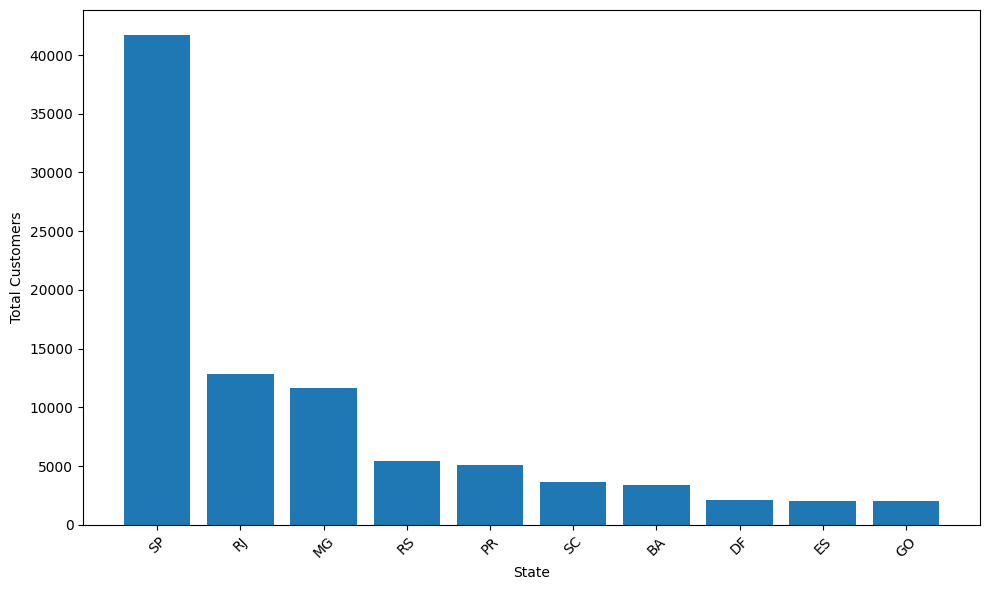

In [214]:
plot_top_states_by_customers(cust_state)

Sao Paulo (SP) memiliki konsentrasi pelanggan tertinggi dan mendominasi secara signifikan dibandingkan negara bagian lain. Distribusi ini menunjukkan bahwa aktivitas e-commerce di Brazil sangat terpusat secara geografis, dengan hanya beberapa negara bagian menyumbang sebagian besar pelanggan.

#### Top 10 States by Revenue

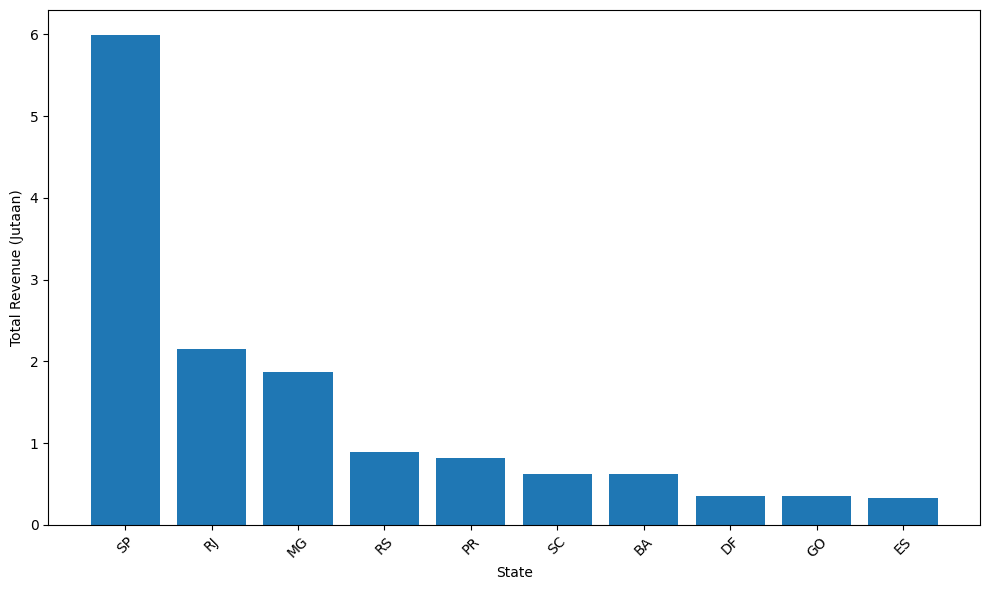

In [215]:
plot_top_states_by_revenue(revenue_state)

Distribusi total revenue menunjukkan pola yang sejalan dengan konsentrasi pelanggan, di mana negara bagian dengan jumlah pelanggan besar juga berkontribusi signifikan terhadap total pendapatan. Namun, perbedaan urutan antar negara bagian mengindikasikan variasi nilai transaksi rata-rata.

#### Customers VS Revenue

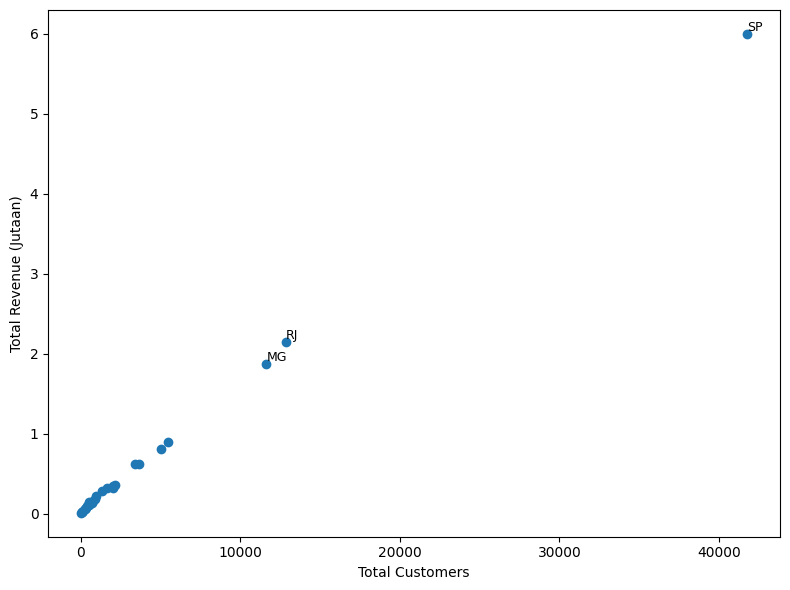

In [216]:
plot_customers_vs_revenue(
    state_summary,
    highlight_states=['SP', 'RJ', 'MG']
)


Terlihat hubungan positif antara jumlah pelanggan dan total revenue. Namun, beberapa negara bagian menyimpang dari pola umum, mengindikasikan perbedaan nilai transaksi antar wilayah.

#### Average Revenue Per Customer

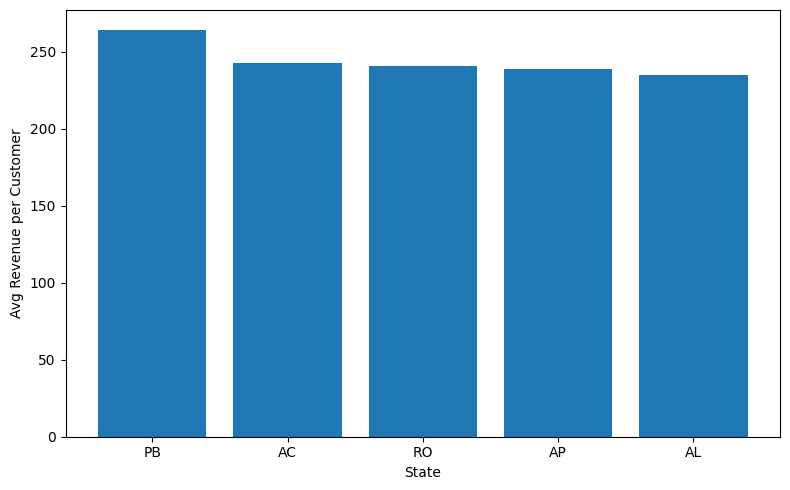

In [217]:
plot_avg_revenue_per_customer(avg_rev_customer)

Meskipun tidak memiliki jumlah pelanggan besar, beberapa negara bagian menunjukkan nilai transaksi rata-rata per pelanggan yang lebih tinggi.

#### Ringkasan Data

In [218]:
state_summary_table = build_state_summary_table(
    state_summary,
    avg_rev_customer
)

top_data(state_summary_table, n=10)

,customer_state,total_customers,total_revenue,avg_revenue_per_customer
0,SP,41746,5998226.96,143.683873
1,RJ,12852,2144379.69,166.851828
2,MG,11635,1872257.26,160.915966
3,RS,5466,890898.54,162.989122
4,PR,5045,811156.38,160.784218
5,SC,3637,623086.43,171.318787
6,BA,3380,616645.82,182.439592
7,DF,2140,355141.08,165.953776
8,ES,2033,325967.55,160.338195
9,GO,2020,350092.31,173.313025


### Pertanyaan 2:

#### Functions

In [219]:
def plot_delivery_vs_review(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(df['delivery_time_days'], df['review_score'], alpha=0.3)
    ax.set_xlabel("Delivery Time (days)")
    ax.set_ylabel("Review Score")
    ax.set_title("Delivery Time vs Review Score")
    plt.tight_layout()
    plt.show()

def plot_review_by_delivery_bin(df):
    df = df.copy()
    df['delivery_bin'] = pd.cut(
        df['delivery_time_days'],
        bins=[0, 7, 14, 21, 30, df['delivery_time_days'].max()],
        labels=['≤7', '8–14', '15–21', '22–30', '>30']
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    df.boxplot(column='review_score', by='delivery_bin', ax=ax)
    ax.set_xlabel("Delivery Time (days)")
    ax.set_ylabel("Review Score")
    ax.set_title("Review Score by Delivery Time Group")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()


#### Review Score vs Delivery Time

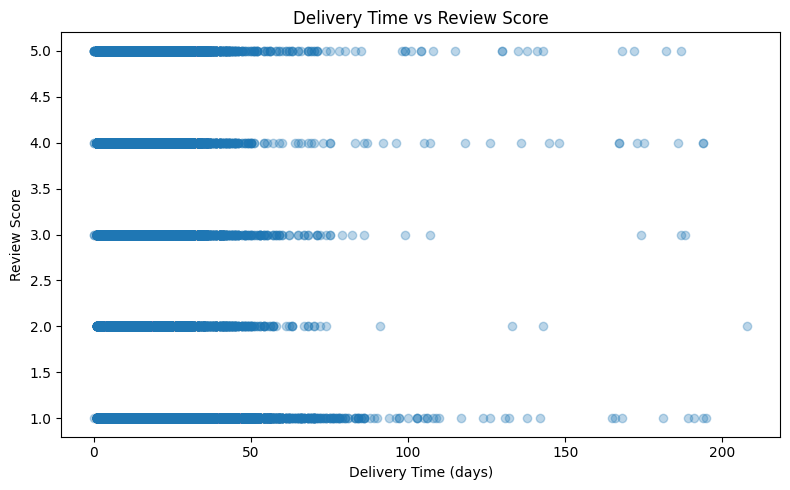

In [220]:
plot_delivery_vs_review(delivery_review)

#### Review Score by Delivery Time

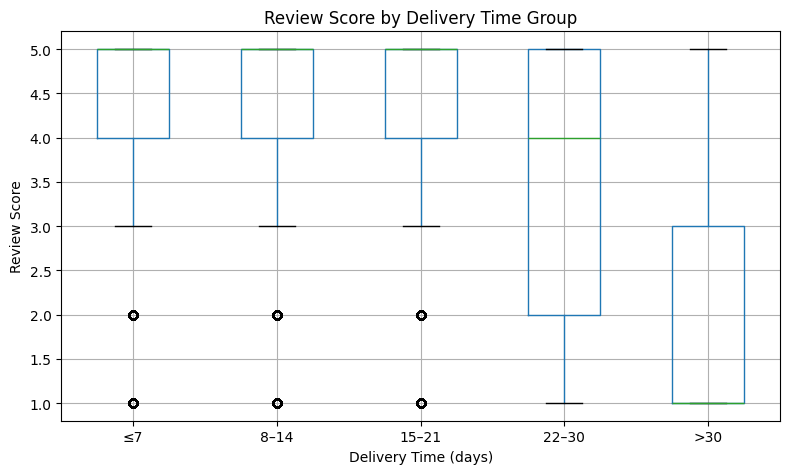

In [221]:
plot_review_by_delivery_bin(delivery_review)

#### Ringkasan Data

In [222]:
delivery_review[['delivery_time_days', 'review_score']].corr(method='spearman')

,delivery_time_days,review_score
delivery_time_days,1.000000,-0.234408
review_score,-0.234408,1.000000


**Insight:**
> Terdapat korelasi negatif lemah antara lama waktu pengiriman dan skor ulasan pelanggan. Hal ini menunjukkan bahwa pengiriman yang lebih lama cenderung diikuti oleh penurunan skor ulasan.

## Analisis Lanjutan (Opsional)

## Conclusion

### Pertanyaan 1

> Negara bagian dengan konsentrasi pelanggan tertinggi di Brazil adalah Sao Paulo (SP).
SP mencatat 41.746 pelanggan, jauh melampaui negara bagian lain seperti Rio de Janeiro (RJ) dan Minas Gerais (MG). Hal ini menunjukkan bahwa basis pelanggan e-commerce sangat terkonsentrasi di wilayah tenggara Brazil, khususnya SP.

---

Distribusi Total Revenue antar Negara Bagian
- Sao Paulo (SP) juga menjadi kontributor revenue terbesar, dengan total pendapatan sekitar 5,99 juta, hampir 3 kali lipat dari RJ dan MG.
- RJ (2,14 juta) dan MG (1,87 juta) berada di posisi kedua dan ketiga, mengonfirmasi dominasi wilayah Southeast dalam aktivitas ekonomi.
- Negara bagian lain seperti RS, PR, dan SC menunjukkan kontribusi menengah, sedangkan negara bagian di luar wilayah selatan dan tenggara memberikan kontribusi revenue yang relatif kecil.

Distribusi ini sangat tidak merata, di mana sebagian besar pendapatan terkonsentrasi pada sedikit negara bagian dengan basis pelanggan besar.

---

Kesimpulan Akhir
- SP adalah pusat utama pelanggan dan revenue e-commerce di Brazil
- Distribusi revenue antar negara bagian sangat timpang
- Volume-driven states ≠ high-value states
- Strategi bisnis dapat dibedakan:
  - Scale & volume, fokus di SP, RJ, MG
  - High-value customers, eksplor negara bagian kecil dengan average spending tinggi

Kesimpulan ini menjawab langsung bahwa konsentrasi pelanggan dan revenue terbesar berada di SP, namun pola pengeluaran pelanggan bervariasi antar negara bagian dan tidak selalu sejalan dengan jumlah pelanggan.

### Pertanyaan 2

> Ya, terdapat korelasi antara lama waktu pengiriman (delivery time) dan skor ulasan pelanggan, namun korelasinya bersifat negatif dan lemah.

---

Ringkasan Temuan Utama
1. Pengiriman cepat = skor ulasan tinggi

- Pada rentang ≤7 hingga 21 hari, median skor ulasan konsisten di 5.0 (sangat puas).

- Variasi skor kecil, menandakan pengalaman pelanggan relatif stabil saat pengiriman cepat.

2. Semakin lama pengiriman = penurunan skor ulasan

- Pada rentang 22–30 hari, median skor mulai turun ke 4.0 dan sebaran ulasan menjadi lebih lebar.

- Pada pengiriman >30 hari, median skor jatuh drastis ke 1.0, dengan kuartil 75% hanya mencapai 3.0.

3. Outlier memperkuat pola negatif

- Skor 1.0 (sangat kecewa) menunjukkan jumlah pencilan terbanyak pada delivery time ekstrem (>150 hari).

- Sebaliknya, skor 5.0 hampir seluruhnya terkonsentrasi pada pengiriman ≤50 hari, dengan outlier sangat jarang.

4. Korelasi numerik mendukung pola visual

- Korelasi Spearman sebesar −0.234 mengindikasikan hubungan negatif lemah: pengiriman lebih lama cenderung diikuti skor ulasan yang lebih rendah, namun bukan satu-satunya faktor penentu kepuasan.

---

Kesimpulan Akhir
> Terdapat korelasi negatif antara lama waktu pengiriman dan skor ulasan pelanggan.
Pengiriman yang lebih cepat secara konsisten dikaitkan dengan skor ulasan yang lebih tinggi, sedangkan pengiriman yang sangat lama (>30 hari) menunjukkan penurunan signifikan pada kepuasan pelanggan. Namun, karena kekuatan korelasinya relatif lemah, waktu pengiriman bukan satu-satunya faktor yang memengaruhi skor ulasan, melainkan berinteraksi dengan faktor lain seperti kualitas produk dan layanan penjual.